# ML Pipeline Preparation

## 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np
import re
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
# from sklearn.datasets import make_multilabel_classification
from sklearn.neighbors import KNeighborsClassifier

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download(['punkt', 'wordnet','stopwords', 'averaged_perceptron_tagger'])


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# load data from database
# engine = create_engine('sqlite:///data/DisasterResponse.db')
# name= str('data/DisasterResponse.db').split('/')[1].split('.')[0]
# df = pd.read_sql_table('DisasterResponse.db'',engine)

engine = create_engine('sqlite:///Test.db')
engine.table_names()


['DF1_test', 'main_df']

In [3]:
df = pd.read_sql_table('main_df', engine)
df.shape

(26216, 41)

In [4]:
#Define feature and target variables X and Y
X = df['message']
Y = df.iloc[:,4:]
for i in Y.columns:
    Y[i] = Y[i].apply(lambda x:1 if x>1 else x)

In [5]:

def df_features(sub=False,frac=0.3,df=df,random_state=42):
    """"
    function to automate subset of X,Y if wanted and split
    args:
    sub (Bool,optioal):select True to subset fraction of df and split to train test
    frac (float, optional): if sub True, fraction of df for split (default 0.3)
    df (pandas dataframe object): table to split
    random_state(int):parameter for train test split function
    
    returns: X_train, X_test, y_train, y_test
    """
    
    if sub:
        #get subset of data from df for faster  hyper parameters tuning
        DF = df.copy()
        DF = DF.sample(frac=frac,random_state=random_state)
    else:
        DF=df.copy()
    #Define feature and target variables X and Y
    X = DF['message']
    Y = DF.iloc[:,4:]
    for i in Y.columns:
        Y[i] = Y[i].apply(lambda x:1 if x>1 else x)
    X_train, X_test, y_train, y_test = train_test_split(X, Y)
    
    return X_train, X_test, y_train, y_test

## 2. Write a tokenization function to process your text data

In [6]:
def tokenize(text):
    text = re.sub(r'[^a-zA-Z0-9]',' ',text.lower().strip())
    tokens = word_tokenize(text)
    
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
     # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

    return tokens



## 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [7]:
def model_pipeline(model_Selection = 0):
    models=[KNeighborsClassifier(),RandomForestClassifier()]
    model=models[model_Selection]
    pipeline = Pipeline([
                    ('vect', CountVectorizer(tokenizer=tokenize)),
                    ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(model))
        ])
    return pipeline


## 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [8]:
def fit_pred(prob=False,model_Selection = 0):
    """"
    function to train model using pipeline
    using model_pipeline function
    
    Args:
    prob (Bool): if predict probability also (returns y_predP)
    model_selection (int): 0 for KNN, 1 for random forest (default KNN)
    
    Return: model,y_pred,accuracy and y_predP if prob=True
    """
    
    model = model_pipeline(model_Selection)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = (y_pred == y_test).mean()
    print(f'accuracy:{accuracy.mean()}')
    
    if prob:
        y_predP = model.predict_proba(X_test)
        return  model,y_pred,accuracy,y_predP
    
    return model,y_pred,accuracy

In [51]:
#train KNN
KnnModel,y_pred,accuracy = fit_pred()

accuracy:0.9016527971364713


## 5. Test the model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [52]:
#find less than 85% accuracy columns
cols = list(accuracy[accuracy<0.85].index)
accuracy[accuracy<0.85]

related              0.784864
request              0.835063
aid_related          0.599634
search_and_rescue    0.784712
weather_related      0.746567
direct_report        0.811260
facilities           0.844217
needs                0.693164
conditions           0.746567
dtype: float64

In [56]:
cols = list(accuracy[accuracy<0.85].index)
[print(f'confusion_matrix - {col}(accuracy:\n{confusion_matrix(np.array(y_test.loc[:,col]),y_pred[:,int(y_test.columns.get_loc(col))])}\n') for col in cols];

confusion_matrix - related(accuracy:
[[ 197 1338]
 [  72 4947]]

confusion_matrix - request(accuracy:
[[5378   22]
 [1059   95]]

confusion_matrix - aid_related(accuracy:
[[3825   23]
 [2601  105]]

confusion_matrix - search_and_rescue(accuracy:
[[5038   23]
 [1388  105]]

confusion_matrix - weather_related(accuracy:
[[4788   22]
 [1639  105]]

confusion_matrix - direct_report(accuracy:
[[5248   23]
 [1214   69]]

confusion_matrix - facilities(accuracy:
[[5506    6]
 [1015   27]]

confusion_matrix - needs(accuracy:
[[4467   16]
 [1995   76]]

confusion_matrix - conditions(accuracy:
[[4788   22]
 [1639  105]]



In [120]:
[print(f'classification_report:\n{col}:\n{classification_report(np.array(y_test.loc[:,col]),y_pred[:,int(y_test.columns.get_loc(col))])}\n') for col in cols]

classification_report:
related:
             precision    recall  f1-score   support

          0       0.62      0.48      0.54      1510
          1       0.85      0.91      0.88      5044

avg / total       0.80      0.81      0.80      6554


classification_report:
aid_related:
             precision    recall  f1-score   support

          0       0.76      0.85      0.80      3833
          1       0.75      0.61      0.67      2721

avg / total       0.75      0.75      0.75      6554


classification_report:
direct_report:
             precision    recall  f1-score   support

          0       0.86      0.97      0.91      5279
          1       0.75      0.34      0.47      1275

avg / total       0.84      0.85      0.83      6554


classification_report:
needs:
             precision    recall  f1-score   support

          0       0.80      0.93      0.86      4475
          1       0.77      0.49      0.60      2079

avg / total       0.79      0.79      0.78      6554




[None, None, None, None]

In [57]:
print(classification_report(np.array(y_test),y_pred));

             precision    recall  f1-score   support

          0       0.79      0.99      0.88      5019
          1       0.81      0.08      0.15      1154
          2       0.82      0.04      0.07      2706
          3       0.00      0.00      0.00       537
          4       0.75      0.01      0.02       310
          5       0.82      0.07      0.13      1493
          6       0.00      0.00      0.00       301
          7       0.00      0.00      0.00       220
          8       0.75      0.03      0.05       422
          9       0.87      0.06      0.11       767
         10       0.81      0.04      0.08       576
         11       0.50      0.01      0.02       109
         12       0.00      0.00      0.00       157
         13       0.00      0.00      0.00        65
         14       0.00      0.00      0.00       197
         15       1.00      0.03      0.05       290
         16       0.67      0.02      0.03       835
         17       1.00      0.00      0.00   

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### results:
although we see high accuray, the model is actually *pretty poor*.

the reason is that the data is highy imbalanced, so *accuray is a bad measure*.

we see te lowest accuracy at the balanced columns - where a real prediction had to be made.

* the over all precision is relativatly high, meaning we get an ok FP rate - so we wont get many false alarams when we go to rescue someone.
* however - the recall is really low! that means our FN rate is high! 
we will miss many *real* disaster calls.

In conclusion -  we cant continue with this model.


## 6. Improve the model
Use grid search to find better parameters. 

In [58]:
KnnModel.get_params().keys()

dict_keys(['memory', 'steps', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__estimator__algorithm', 'clf__estimator__leaf_size', 'clf__estimator__metric', 'clf__estimator__metric_params', 'clf__estimator__n_jobs', 'clf__estimator__n_neighbors', 'clf__estimator__p', 'clf__estimator__weights', 'clf__estimator', 'clf__n_jobs'])

In [30]:
def build_model():
    pipeline = Pipeline([
                    ('vect', CountVectorizer(tokenizer=tokenize)),
                    ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(KNeighborsClassifier()))
        ])

    parameters = {
#         'vect__ngram_range': ((1, 1), (1, 2)),
#         'vect__max_df': (0.5, 0.75, 1.0),
#         'vect__max_features': (None, 10000),#(None, 5000, 10000),
#         'tfidf__use_idf': (True, False),
        'clf__estimator__n_neighbors': [15,30],#,8,12],#[10, 50, 100, 200],
        'clf__estimator__p': [2]#1
                
       
    }

    cv = GridSearchCV(pipeline, param_grid=parameters,cv=3)

    return cv


In [26]:
#use function to get only subset of Data from df
X_train, X_test, y_train, y_test = df_features(sub=True)


In [31]:
KNN_better = build_model()
KNN_better.fit(X_train, y_train)
KNN_better.best_params_

{'clf__estimator__n_neighbors': 15, 'clf__estimator__p': 2}

In [32]:
X_train, X_test, y_train, y_test = df_features(sub=False)
KNN_betterfull = model_pipeline()
KNN_betterfull.set_params(**KNN_better.best_params_)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ic_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'),
           n_jobs=1))])

In [33]:
y_pred = KNN_better.predict(X_test)

## 7. Test the model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [34]:
accuracy = (y_pred == y_test).mean()
accuracy.mean()

0.91863850423508642

In [35]:
print(classification_report(np.array(y_test),y_pred))

             precision    recall  f1-score   support

          0       0.82      0.96      0.89      5025
          1       0.80      0.46      0.58      1120
          2       0.72      0.51      0.60      2710
          3       0.60      0.05      0.09       524
          4       0.67      0.08      0.14       316
          5       0.78      0.40      0.53      1475
          6       0.67      0.01      0.01       296
          7       0.67      0.01      0.02       203
          8       0.77      0.12      0.20       426
          9       0.84      0.32      0.46       703
         10       0.83      0.14      0.24       567
         11       0.67      0.17      0.28       103
         12       1.00      0.01      0.01       155
         13       0.00      0.00      0.00        68
         14       0.80      0.02      0.03       236
         15       0.74      0.06      0.11       290
         16       0.65      0.02      0.03       851
         17       0.40      0.00      0.01   

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## results
precision remained pretty much the same, but, we can see that we now have much better recall.

that is a primary goal we have for two reasons:
1. The last model had really poor score for that metric
2. For Disaster domain, Recall is an important metric that we would like to maximize

## 8. try to improve the model further.

### 8.1 - Using RandomForestClassifier

In [36]:
X_train, X_test, y_train, y_test = df_features()
RFCModel,y_pred,accuracy = fit_pred(model_Selection = 1)


accuracy:0.9269189848988446


### 8.2 - Using RandomForestClassifier GridSearch

In [11]:
def build_model(grid=True):
    pipeline = Pipeline([
                    ('vect', CountVectorizer(tokenizer=tokenize)),
                    ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(RandomForestClassifier()))
        ])

    parameters = {
        'vect__ngram_range': ((1, 1), (1, 2)),
        'vect__max_df': (0.75, 1.0),
        'tfidf__use_idf': (True, False),
        'clf__estimator__min_samples_leaf': [1,4]  ,
        'clf__estimator__max_features': [4,6],
        'clf__estimator__n_estimators': [100,120]#,30,50]
    }
    if grid:
        cv = GridSearchCV(pipeline,cv=3,param_grid=parameters)

        return cv
    else:
        return pipeline

In [9]:
#take subset of data for parameter tuning
X_train, X_test, y_train, y_test = df_features(sub=True)
#grid search an cross validation for tree classifier
RF_GS_model = build_model()
RF_GS_model.fit(X_train, y_train)
#best parameters found
RF_GS_model.best_params_

{'clf__estimator__max_features': 6,
 'clf__estimator__min_samples_leaf': 1,
 'clf__estimator__n_estimators': 100,
 'tfidf__use_idf': True,
 'vect__max_df': 1.0,
 'vect__ngram_range': (1, 2)}

In [ ]:
#Train model with full DF
X_train, X_test, y_train, y_test = df_features(sub=False)
#prepare model with only pipeline
RFCmodel = build_model(grid=False)
#set best parameters for model
RFCmodel.set_params(**RF_GS_model.best_params_)
#train model with best parameters
RFCmodel.fit(X_train, y_train)

In [15]:
RFCmodel.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

In [349]:
#evaluate
y_pred = RFCmodel.predict(X_test)
accuracy = (y_pred == y_test).mean()
accuracy.mean()

0.93159943587163607

In [17]:
#classification_report
print(classification_report(np.array(y_test),y_pred,target_names =accuracy.index.tolist()));

                        precision    recall  f1-score   support

               related       0.82      0.97      0.89      5015
               request       0.90      0.36      0.51      1098
           aid_related       0.84      0.37      0.52      2699
          medical_help       0.50      0.01      0.01       553
      medical_products       0.40      0.01      0.01       353
     search_and_rescue       0.88      0.30      0.45      1483
              security       0.00      0.00      0.00       283
              military       0.00      0.00      0.00       200
                 water       0.92      0.09      0.16       387
                  food       0.92      0.19      0.31       731
               shelter       0.94      0.05      0.10       576
              clothing       1.00      0.01      0.02        97
                 money       1.00      0.03      0.06       160
        missing_people       0.00      0.00      0.00        80
              refugees       0.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 9. Optimal Threshold finder and precision recall plot 

In [21]:
from sklearn.metrics import f1_score
def optimal_trashold(y_prob,cols=y_test.columns):
    """"
    Used to gind oplimatl threshold using F1 measure
    Args:
    cols (list): list of df columns to check (default all y columns)
    y_prob (array): array of propabilities prediction
    Returns:
    df of best threshold and f1 score obtain for each categoty
    """
    
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    # apply threshold to positive probabilities to create labels
    def to_labels(pos_probs, threshold):
        return (pos_probs >= threshold).astype('int')
    def cal_thresh(col):
        try:
            # keep probabilities for the positive outcome only
            probs = pd.Series(y_prob)[col].transpose()[1]
        except IndexError:
            probs = pd.Series(y_prob)[col].transpose()[0]
        # evaluate each threshold
        scores = [f1_score(y_test.iloc[:,col], to_labels(probs, t)) for t in thresholds]
        # get best threshold
        ix = np.argmax(scores)

#         print(f'Lable: {y_test.columns[col]},Threshold={thresholds[ix]:,.3f}, F-Score:{scores[ix]:,.5f}')
        return([y_test.columns[col],np.around(thresholds[ix],3),np.around(scores[ix],5)])
    
    list_of_scores = []
    for col in range(len(cols)):
        score = cal_thresh(col)
        list_of_scores.append(score)
        
    df = pd.DataFrame(list_of_scores,columns=('Lable','Threshold','F-Score'))
    return df
        

In [22]:
y_prob = RFCmodel.predict_proba(X_test)
list_of_scores = optimal_trashold(y_prob)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
def color_positive_green(val,thresh=0.5):
    """
    Takes a scalar and returns a string with
    the css property `'color: green'` for positive
    strings, black otherwise.
    """
    if val > thresh:
        color = 'green'
    else:
        color = 'red'
    return 'color: %s' % color
# list_of_scores.style.set_properties(**{'background-color': 'black','color': 'white'})
list_of_scores.sort_values('Threshold').style.applymap(color_positive_green, subset=['F-Score'])

,Lable,Threshold,F-Score
22,aid_centers,0.041,0.104
12,money,0.061,0.27753
23,other_infrastructure,0.068,0.19192
20,electricity,0.071,0.39744
17,infrastructure_related,0.081,0.25035
14,refugees,0.081,0.28516
29,cold,0.081,0.35955
13,missing_people,0.081,0.16783
7,military,0.081,0.47471
27,fire,0.081,0.36036


In [30]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def plot_optimal_trashold(cols,color='orange'):
    """
    plot recision recall plots
    
    Args:
    cols (list): list of columns to plot
    color (str): color of plot curve (default orange)
    """
    
    def plot_thresh(col,color=color):
            try:
                # keep probabilities for the positive outcome only
                probs = pd.Series(y_prob)[col].transpose()[1]
            except IndexError:
                print(f'col {y_test.columns[col]} has no predictions')
                probs = pd.Series(y_prob)[col].transpose()[0]
         
            # calculate roc curves
            precision, recall, thresholds = precision_recall_curve(y_test.iloc[:,col], probs)
            # convert to f score
            fscore = (2 * precision * recall) / (precision + recall)
            # locate the index of the largest f score
            ix = argmax(fscore)
            # plot the roc curve for the model
            no_skill = len(y_test.iloc[:,1][y_test.iloc[:,col]==col]) / len(y_test.iloc[:,col])
            pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
            pyplot.plot(recall, precision, marker='.',color=color, label=y_test.columns[col])
            pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
            # axis labels
            pyplot.xlabel('Recall')
            pyplot.ylabel('Precision')
            pyplot.legend()
            plt.title(f'\nCategory: {y_test.columns[col]}\nBest Threshold: {thresholds[ix]:,.3f}, F-Score:{fscore[ix]:,.3f} ')

    print('Precision-Recall Curve\n-----------------------')

    columns = 3
    row = len(cols)/columns
    if row<1:row=1
    height = row*5
    plt.figure(figsize=(15,height))
    plt.tight_layout()
    for i,col in enumerate(cols,1):
        try:
            plt.subplot(row,columns,i)
            plot_thresh(col)
        except ValueError:
            pass

Precision-Recall Curve
-----------------------


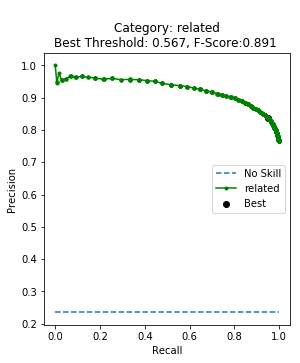

In [31]:
scoreCol = list_of_scores.index[list_of_scores['F-Score']>=0.75].tolist()
plot_optimal_trashold(cols=scoreCol,color='green')

Precision-Recall Curve
-----------------------


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


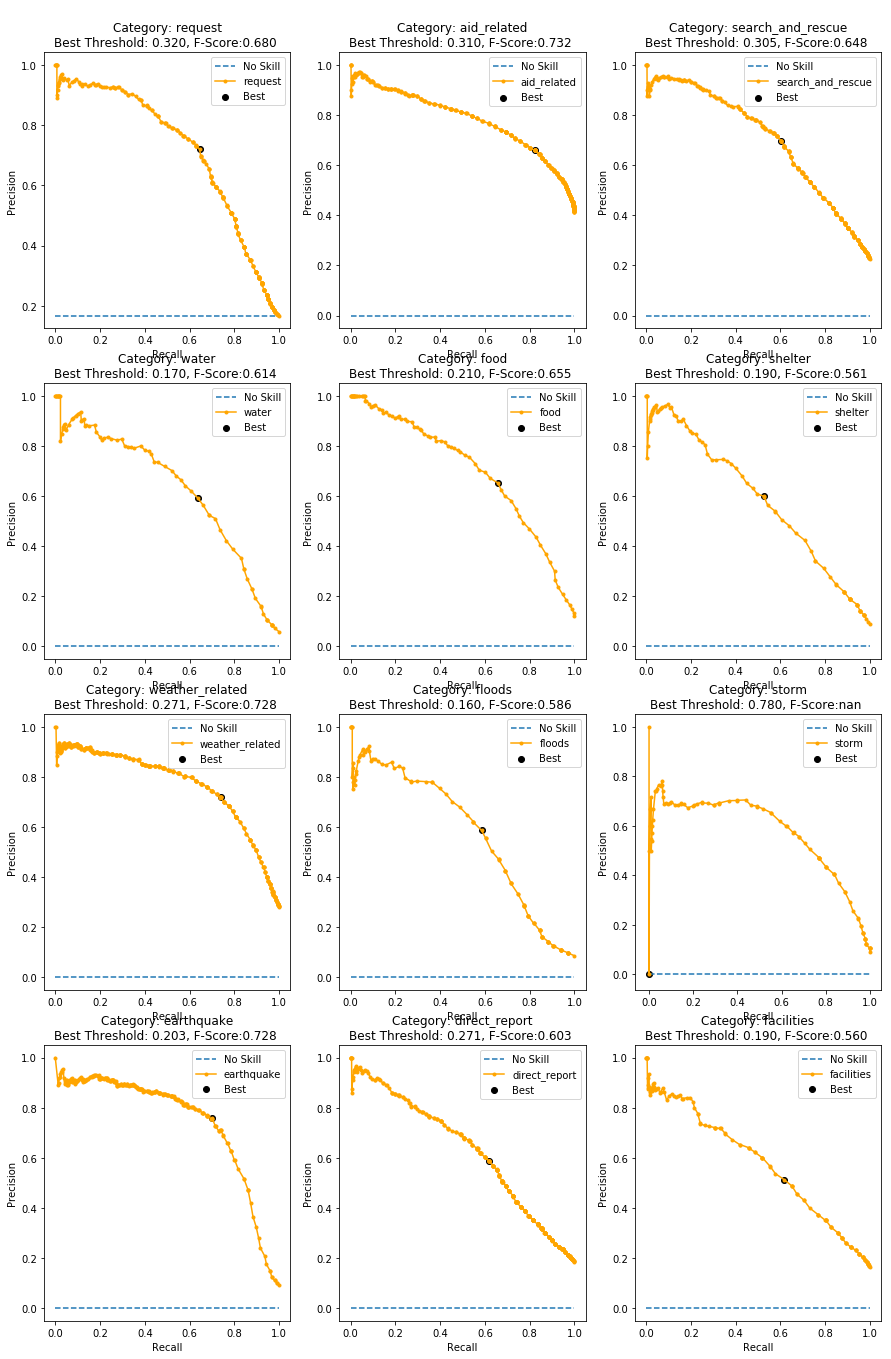

In [33]:
scoreCol = list_of_scores.index[list_of_scores['F-Score'].between(0.6,0.75)].tolist()
plot_optimal_trashold(cols=scoreCol,color='orange')

Precision-Recall Curve
-----------------------


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


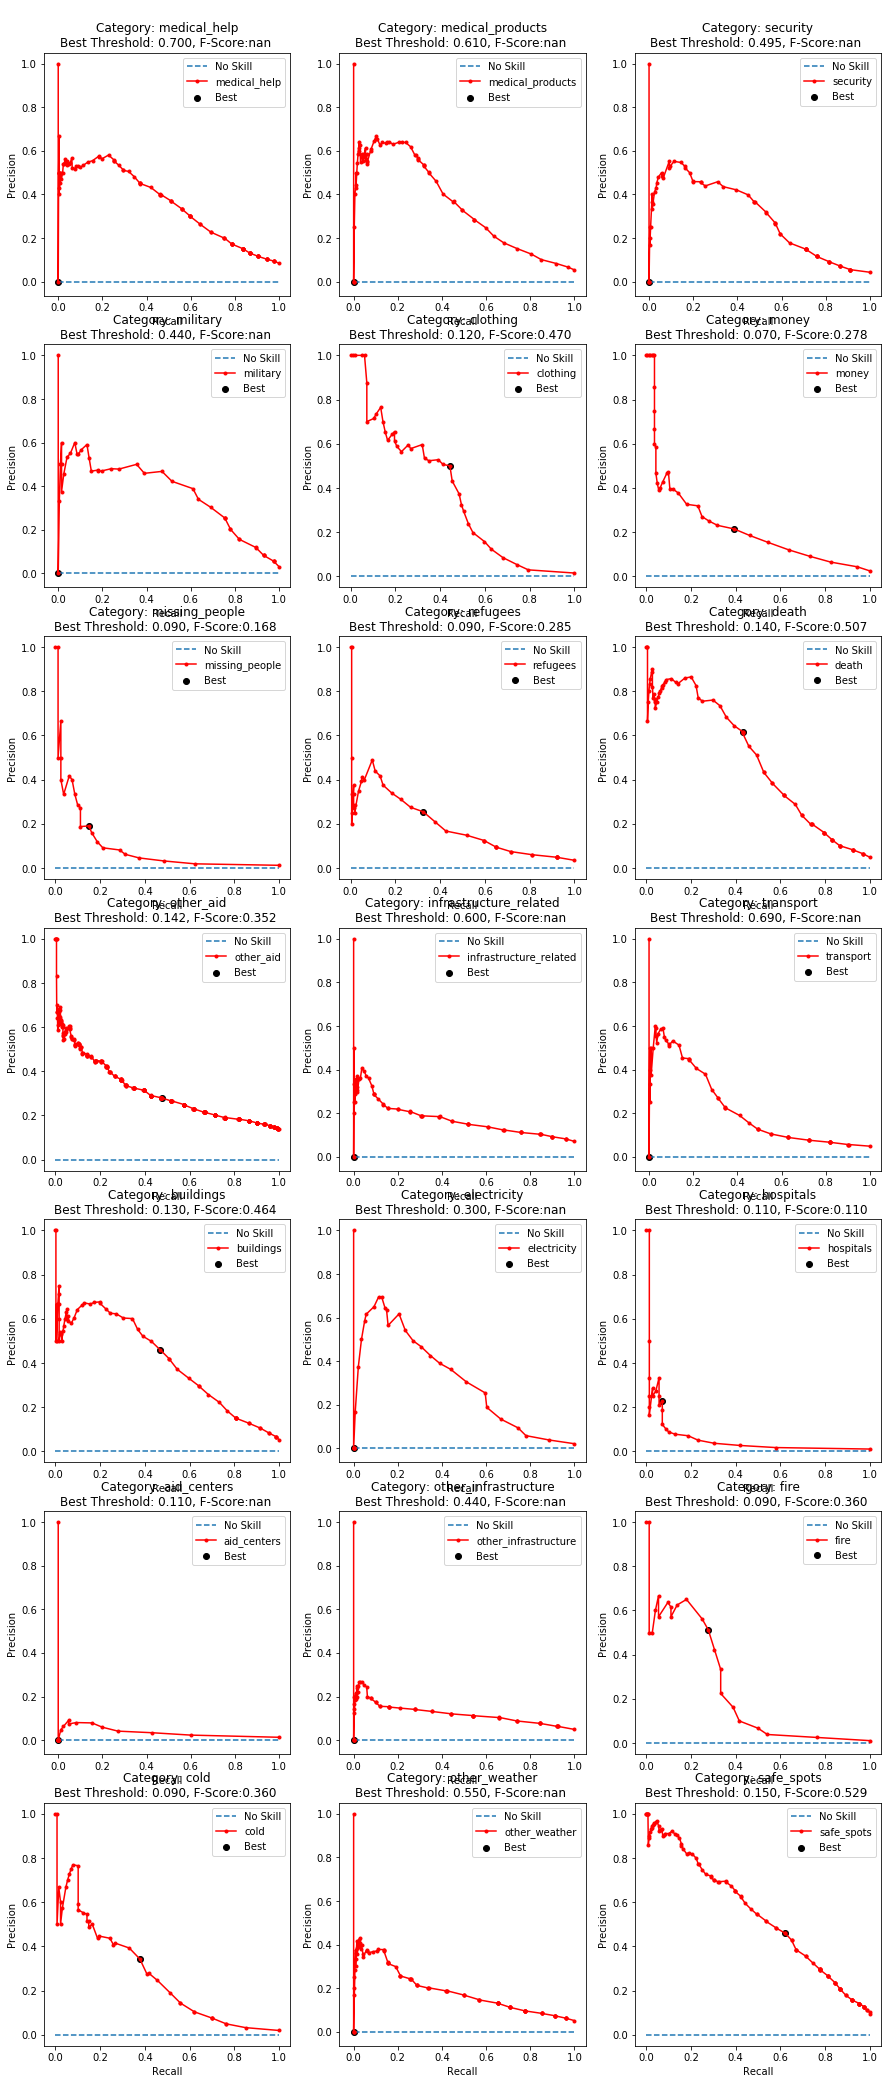

In [34]:
scoreCol = list_of_scores.index[list_of_scores['F-Score']<=0.55].tolist()
plot_optimal_trashold(cols=scoreCol,color='red')

In [52]:
trusted_categories = list_of_scores[list_of_scores['F-Score']>0.6]

print(f'Categories to be trusted for predictionn\n\nMean scores:\n{trusted_categories.mean()}')
trusted_categories

Categories to be trusted for predictionn

Mean scores:
Threshold    0.275333
F-Score      0.691920
dtype: float64


,Lable,Threshold,F-Score
0,related,0.567,0.89088
1,request,0.311,0.68044
2,aid_related,0.311,0.73188
5,search_and_rescue,0.304,0.64765
8,water,0.161,0.61366
9,food,0.201,0.65484
24,weather_related,0.276,0.72817
26,storm,0.154,0.61157
28,earthquake,0.201,0.72837
31,direct_report,0.271,0.60264


In [58]:
Untrusted_categories = list_of_scores[list_of_scores['F-Score']<=0.6]

print(f'Categories that should be improved before deployment\n\nMean scores:\n{trusted_categories.mean()}')

Untrusted_categories.sort_values('F-Score').style.applymap(color_positive_green, subset=['F-Score'])

Categories that should be improved before deployment

Mean scores:
Threshold    0.107680
F-Score      0.373715
dtype: float64


,Lable,Threshold,F-Score
22,aid_centers,0.041,0.104
21,hospitals,0.101,0.10989
13,missing_people,0.081,0.16783
23,other_infrastructure,0.068,0.19192
17,infrastructure_related,0.081,0.25035
30,other_weather,0.084,0.26055
12,money,0.061,0.27753
14,refugees,0.081,0.28516
18,transport,0.111,0.30508
16,other_aid,0.141,0.35203


### results:
after some parameter tuning - this is a better model.

* The overall precision remained the same
* However - the recall is now more than doubled in score! that means we will now be able to detect more real cases (or miss less real cases), and in disaster domain, its more important.
* Different treshold should be chosen for each class in future predictions - which will maximize results
* The plots below shows the dramatic change in f1 score after tuning




In [135]:
f1 = f1_score(np.array(y_test),y_pred,average=None)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [146]:
f1_before = pd.Series(f1,index=list_of_scores['Lable'])

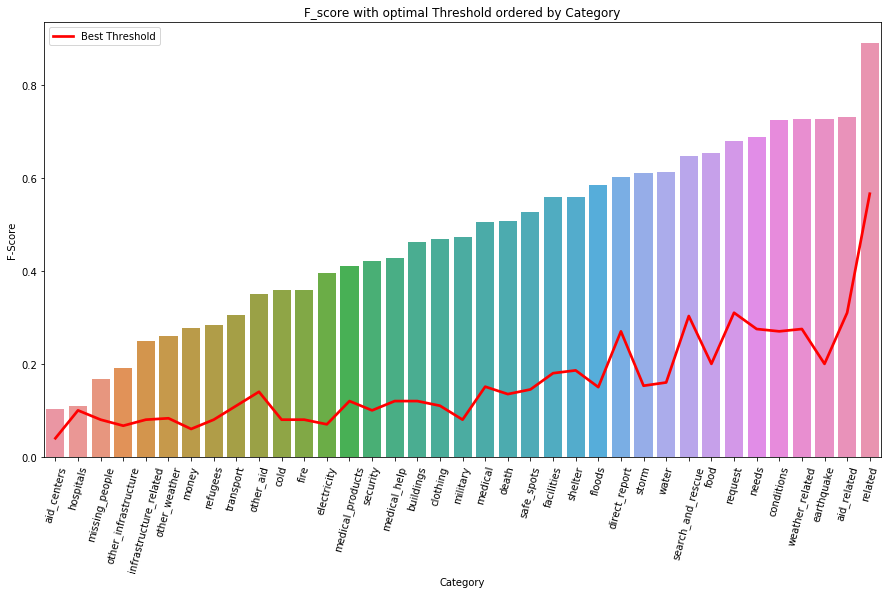

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,8))
df1 = list_of_scores.sort_values('F-Score')
sns.pointplot(x='Lable',y="Threshold", data=df1,color='red');
sns.barplot(x='Lable',y="F-Score", data=df1);
plt.xticks(rotation=75);
plt.legend(['Best Threshold']);
plt.title('F_score with optimal Threshold ordered by Category');
plt.xlabel('Category');

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


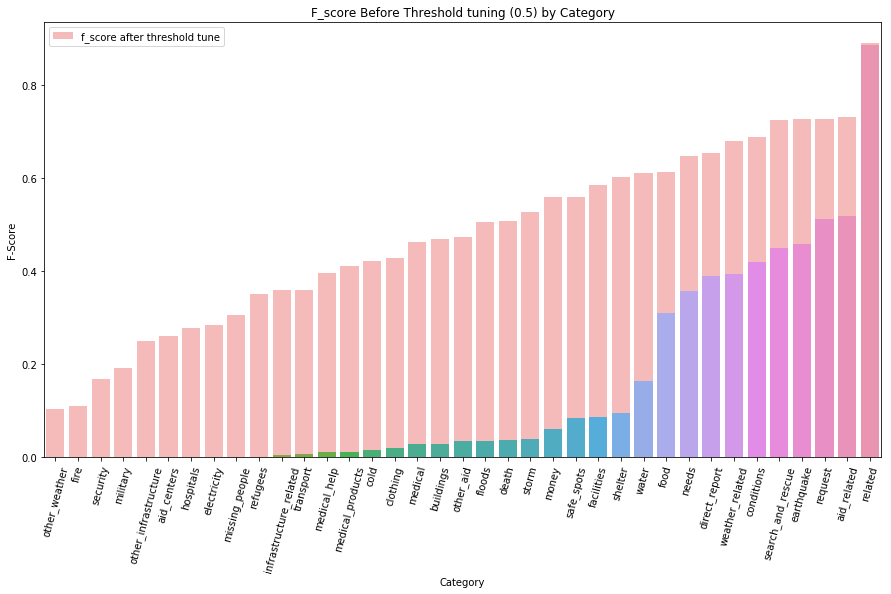

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
f1 = f1_score(np.array(y_test),y_pred,average=None)
f1_before = pd.Series(f1,index=y_test.columns)
plt.figure(figsize=(15,8))
df2 = f1_before.sort_values()
sns.barplot(x='Lable',y="F-Score", data=df1,color='r',label='f_score after threshold tune',alpha=0.3);
sns.barplot(x=df2.index,y=df2.values,alpha=1);
plt.xticks(rotation=75);
plt.xlabel('Category');
plt.legend();
plt.title('F_score Before Threshold tuning (0.5) by Category');

# Metrics meaning for Disaster Response Domain
***

<table >

  <tr>
    <th style="background-color:gray">Metric</th>
     <th style="background-color:gray" >What does that even means</th>
    <th style="background-color:#00FF00">Why it's OK</th>
    <th style="background-color:red">Why it's NOT OK</th>
    <th style="background-color:orange">What should we do?</th>
  </tr>
  <tr>
    <td colspan="1" rowspan="2">Precision</td>
    <td>Low precision means we will get a high False Positive rate</td>
    <td rowspan="2">In case of irrelevance  - the call would just be ignored </td>
    <td>In case of Disaster  - many calls will be sent, and that may cause an unnecessary load</td>
    <td rowspan="2">For classes that are'nt life or resource allocation crucial - medium to high threshold should be chosen</td>
  </tr>
  <tr>
    <td>Practically, that means we will send a wrong agency the message call.</td>
    <td>There could be a situation where an agency sends resources by mistake - that might cause an insufficient resource allocation for the real needed calls</td>
  </tr>
  <tr>
    <td colspan="1" rowspan="2">Recall</td>
    <td >Low Recall means a High False Negative rate</td>
    <td rowspan="2">Some topics are not crucial and can go undetected like reports that aren’t important for help</td>
    <td >practically - that means agencies will not get the distress call - because it will be classified as False by mistake</td>
    <td rowspan="2">For classes that Are life or resource allocation crucial - low to  threshold should be chosen</td>
    </tr>
    <tr>
    <td >In case of emergency, its crucial not to miss any stress calls that revolve saving life’s</td>
    <td >In this domain - for life saving classes, there soul'd be an attempt to get the lowest FN rate as possible</td>
    </tr>
</table>

### 9. Export your model as a pickle file

In [ ]:
pd.to_pickle(RFCmodel,'temp')